# TP K-nearest Neighbors - Inteligencia Artificial

### Integrantes: 
* Alegre, Nicolas
* Enrique, Gerardo
* Zaracho, Santino
* Zimmermann, Federico

## Generando datos aleatorios para la entrada del algoritmo

La entrada del algoritmo K-nearest Neighbors serán conjuntos de puntos en 2 dimensiones (x,y). Para generar de forma rápida estos conjuntos de puntos, hemos decidido generarlos de forma aleatoria siguiendo una distribución normal N(mu,sigma) donde mu (media del conjunto) y sigma (desviación estándar del conjunto) serán parámetros dados. Para esto utilizamos la librería Numpy, que nos permite utilizar muchas funciones ya construídas que nos facilita el desarrollo. Además Numpy hace uso de la vectorización para realizar operaciones, lo cual hace al código mucho más performante.

También haremos uso de la librería Matplotlib para graficar los puntos obtenidos

### Importar librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Definir función para generar datos aleatorios de una clase

In [2]:
def generate_random_class_points(mean_x, stdev_x, mean_y, stdev_y, n, label):
    """This function receives as input:
            mean_x: The mean of x coordinate.
            stdev_x: The standard deviation of x coordinate.
            mean_y: The mean of y coordinate.
            stdev_y: The standard deviation of y coordinate.
            n: The number of points of the class.
            label: The label of the class.
        
        Returns: A numpy array of shape (n,3) containing the points in this format [x y classLabel]
    """
    x = np.random.normal(mean_x, stdev_x, n)
    y = np.random.normal(mean_y, stdev_y, n)
    
    return np.array([x, y, np.full(x.shape, label)]).transpose()

In [3]:
group1 = generate_random_class_points(0, 2, 1, 1, 1000, 1)
group2 = generate_random_class_points(3, 2, 3, 1, 1000, 2)
group3 = generate_random_class_points(-3, 2, 5, 1, 1000, 3)
group4 = generate_random_class_points(5, 1, 8, 1, 1000, 4)
group5 = generate_random_class_points(8, 2, 5, 1, 1000, 5)

In [4]:
group3

array([[-3.98859296,  5.22677807,  3.        ],
       [-4.50306643,  4.75333272,  3.        ],
       [-0.65343174,  6.12339735,  3.        ],
       ...,
       [-4.71801483,  3.08940925,  3.        ],
       [-3.6693279 ,  4.61827902,  3.        ],
       [-0.93547529,  5.54664318,  3.        ]])

### Definir función para graficar los puntos de una clase

In [5]:
def plot_class(group,label,color):
    plt.plot(group[:,0:1], group[:,1:2],color+"o",label=label,ms=4.0)
    plt.legend()

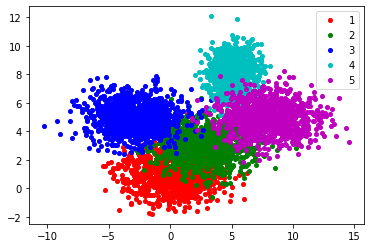

In [6]:
colors = ["r","g","b","c","m"]
classes = [group1,group2,group3,group4,group5]
for i in range(len(classes)):
    plot_class(classes[i],i+1,colors[i])

En los siguientes gráficos podemos ver que efectivamente cada clase tiene puntos donde ambas coordenadas están distribuidas según la distribución Normal definida.  

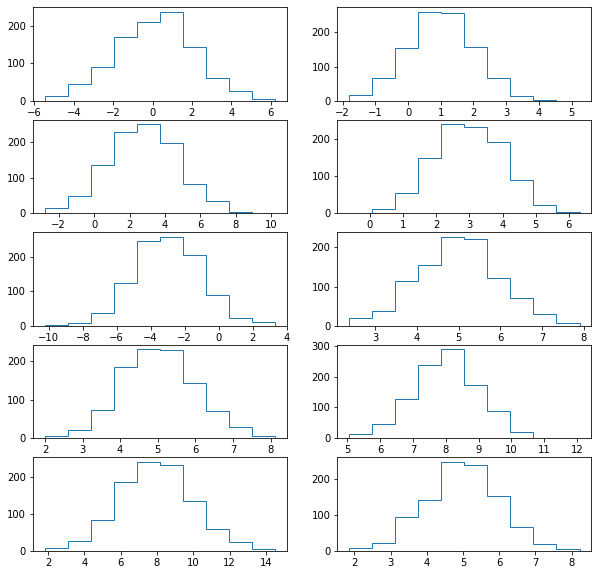

In [7]:
%matplotlib inline
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42), (ax51, ax52)) = plt.subplots(5, 2, figsize=(10,10))
ax11.hist(group1[:,0:1], histtype='step')
ax12.hist(group1[:,1:2], histtype='step')
ax21.hist(group2[:,0:1], histtype='step')
ax22.hist(group2[:,1:2], histtype='step')
ax31.hist(group3[:,0:1], histtype='step')
ax32.hist(group3[:,1:2], histtype='step')
ax41.hist(group4[:,0:1], histtype='step')
ax42.hist(group4[:,1:2], histtype='step')
ax51.hist(group5[:,0:1], histtype='step')
ax52.hist(group5[:,1:2], histtype='step');

## Calculando distancias entre dos puntos

El primer paso para clasificar un punto nuevo que llega es calcular la distancia entre este punto nuevo y cada punto existente en el dominio (de cada clase). Para calcular la distancia utilizamos la fórmula Euclidiana.

Una vez calculada la distancia a cada punto que exista, deberíamos identificar qué puntos del dominio se encuentran más cercanos a este nuevo punto dado y también identificar la etiqueta de clase de estos puntos más cercanos.

### Agrupamos las tres clases en un sólo conjunto.
Como las clases ya están etiquetadas, no perderemos la información de a qué clase pertenecen

In [8]:
def join_groups(groups):
    """This function joins the groups generated in one unique np.array.
       The result of this function is the set 'predictors' for future usage.
       The input must be a tuple containing the groups of points generated befor of shape (n,3) where each point has [x y class]. 
    """
    
    return np.concatenate(groups, axis=0)

In [9]:
total = join_groups((group1,group2,group3,group4,group5))
total.shape

(5000, 3)

### Generamos un nuevo punto aleatorio
En este caso con la misma distribución normal que el grupo 1, por lo que tendría que haber más posibilidades de que este nuevo punto sea clasificado como perteneciente al Grupo 1.

In [10]:
#We generate a new point with the same Distribution as Group1.
new_point = np.array([np.random.normal(5,1), np.random.normal(3,1)]).transpose()
new_point

array([4.63005502, 2.56419715])

### Graficamos para ver donde se encuentra el nuevo punto con respecto a los conjuntos

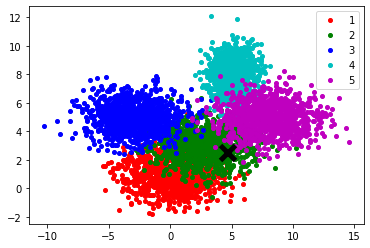

In [11]:
plot_class(group1,1,"r")
plot_class(group2,2,"g")
plot_class(group3,3,"b")
plot_class(group4,4,"c")
plot_class(group5,5,"m")
plt.plot(new_point[0],new_point[1],marker="x",markeredgecolor="black",mew=5,ms=15);

### Calculamos las distancias y las ordenamos en orden ascendente

In [12]:
def calculate_distance(new_point, arr):
    """
    This function calculates the distance between a set of n points (given) and a new point (also given).
    It returns an erray of shape (n,2) with the results of distances between the new point and each point of the set
    and the class' label. This returned array is already sorted by the distance.
    """

    distance = 0.0
    for i in range(2):
        distance += (new_point[i] - arr[:,i:i+1])**2
        
    distances = np.concatenate((np.sqrt(distance),arr[:,2:3]),axis=1)
    sorted_distances = distances[distances[:,0].argsort()] 
    
    return sorted_distances

In [13]:
distances = calculate_distance(new_point,total)
distances

array([[ 0.07389992,  2.        ],
       [ 0.0962572 ,  2.        ],
       [ 0.13060727,  2.        ],
       ...,
       [13.67644791,  3.        ],
       [13.96322232,  3.        ],
       [14.98109223,  3.        ]])

## Determinamos los puntos más cercanos

A continuación se deberían examinar los k primeras filas del array de las distancias. Se cuenta cuantos puntos hay de cada clase en esas primeras k filas y se asocia este nuevo punto a la clase que mayor cuenta logró (osea, la clase que más puntos cercanos tiene a este nuevo punto). También se calcula la confianza de la predicción, la cual se obtiene dividiendo la cantidad de vecinos proximos encontrados de la clase resultante, entre k.

In [14]:
def define_class(k,distances):
    """
        This funtion takes the k argument and an ordered distances-array and returns the most repetitive class of the
        first k points (k nearest points)
    """
    
    counts = np.bincount(distances[:k,1].astype(int))
    group = np.argmax(counts)
    confidence = counts[group]/k
    return (group,confidence)

In [15]:
define_class(5, distances)

(2, 1.0)

In [16]:
def knn_predict(predictors, point, k):
    """
        This function predicts the class of a new_point given the set of numbers for training and the k argument
    """
    
    sorted_distances = calculate_distance(point, predictors)
    return define_class(k, sorted_distances)

In [17]:
knn_predict(total, new_point,7)

(2, 1.0)

## Generamos la grilla

Utilizamos nuestra función de predicción para predecir cada punto de una grilla sobre el gráfico de puntos. Graficamos esta grilla para poder ver las zonas donde nuestro algoritmo clasifica para determinadas clases. Aquí podemos ver también facilmente si nuestro algoritmo clasifica bien o no algunos puntos

In [18]:
def make_prediction_grid(points, limits, h, k):
    """
        This function takes as input the predictors points of the set (this points already have their class associated
        in the array), then also takes the limits of the future grid, an argument h which is the step number for making
        the grid and the k required to predict each point of the grid with knn algorythm.
        
        
        Ir returns the x coordinates of the grid as xx,
        the y coordinates of the grid as yy,
        the class evaluated for each point of the grid as prediction_grid,
        the confidence of each prediction of the grid as confidence_grid.
    """
    
    x_min, x_max, y_min, y_max = limits
    xs = np.arange(x_min, x_max, h)
    ys = np.arange(y_min, y_max, h)
    xx, yy = np.meshgrid(xs,ys)
    
    prediction_grid = np.zeros(xx.shape, dtype=int)
    confidence_grid = np.zeros(xx.shape, dtype=float)
    
    for i,x in enumerate(xs):
        for j,y in enumerate(ys):
            p = np.array([x,y])
            prediction_grid[j,i], confidence_grid[j,i] = knn_predict(points, p, k)
    return (xx, yy, prediction_grid, confidence_grid)

In [19]:
xx, yy, prediction_grid, confidence_grid = make_prediction_grid(total, (-11,15,-4,13),0.2, 5)

In [20]:
print(xx)
print("")
print(yy)
print("")
print(prediction_grid)

[[-11.  -10.8 -10.6 ...  14.4  14.6  14.8]
 [-11.  -10.8 -10.6 ...  14.4  14.6  14.8]
 [-11.  -10.8 -10.6 ...  14.4  14.6  14.8]
 ...
 [-11.  -10.8 -10.6 ...  14.4  14.6  14.8]
 [-11.  -10.8 -10.6 ...  14.4  14.6  14.8]
 [-11.  -10.8 -10.6 ...  14.4  14.6  14.8]]

[[-4.  -4.  -4.  ... -4.  -4.  -4. ]
 [-3.8 -3.8 -3.8 ... -3.8 -3.8 -3.8]
 [-3.6 -3.6 -3.6 ... -3.6 -3.6 -3.6]
 ...
 [12.4 12.4 12.4 ... 12.4 12.4 12.4]
 [12.6 12.6 12.6 ... 12.6 12.6 12.6]
 [12.8 12.8 12.8 ... 12.8 12.8 12.8]]

[[1 1 1 ... 5 5 5]
 [1 1 1 ... 5 5 5]
 [1 1 1 ... 5 5 5]
 ...
 [3 3 3 ... 5 5 5]
 [3 3 3 ... 5 5 5]
 [3 3 3 ... 5 5 5]]


In [21]:
def plot_prediction_grid (xx, yy, prediction_grid, confidence_grid, predictors):
    """ 
    Plot KNN predictions for every point on the grid. The background is the prediction of every point of the grid
    and the circular points are the real points of the set and their classifications.
    """
    from matplotlib.colors import ListedColormap
    background_colormap = ListedColormap (["hotpink","yellowgreen", "lightskyblue","navajowhite","plum"])
    observation_colormap = ListedColormap (["red","green","blue","darkorange","blueviolet"])
    plt.figure(figsize =(15,15))
    # pcolormesh paints the grid using the prediction grid
    plt.pcolormesh(xx, yy, prediction_grid, cmap = background_colormap, alpha = 0.5)
    plt.scatter(predictors[:,0], predictors[:,1], c = predictors[:,2], cmap = observation_colormap, s = 50, edgecolor="black", linewidth=0.3)
    plt.xlabel('X coordinate'); plt.ylabel('Y coordinate')
    plt.xticks(()); plt.yticks(())
    plt.xlim (np.min(xx), np.max(xx))
    plt.ylim (np.min(yy), np.max(yy))

In [22]:
def plot_prediction_confidence_grid(xx, yy, prediction_grid, confidence_grid, predictors, h):
    
    """
    This function plots the grid but now considering the confidence of each prediction. The background now doesn't have
    always the same alpha value (or transparency), More transparency means less confidence on the prediction. More opacity
    means more confidence on the prediction.
    Here, the pcolormesh function cannot take differents values of alpha, so we should construct every single rectangle of 
    the figure and give it a transparency (alpha) value.
    """
    
    from matplotlib.patches import Rectangle, Patch
    from matplotlib.colors import ListedColormap

    norm = plt.Normalize(prediction_grid.min(), prediction_grid.max())
    background_colormap = ListedColormap (["hotpink","yellowgreen", "lightskyblue","navajowhite","plum"])
    observation_colormap = ListedColormap (["red","green","blue","darkorange","blueviolet"])
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1)

    for i in range(len(xx[0]) - 1):
        for j in range(len(yy) - 1):
            rect = Rectangle((xx[0][i], yy[j][0]), h, h,
                             facecolor=background_colormap(norm(prediction_grid[j, i])), alpha=confidence_grid[j, i], edgecolor='black', linewidth=0.1)
            ax.add_patch(rect)
    
    ax.relim()
    ax.autoscale(enable=True, tight=True)
    ax.scatter(predictors[:,0], predictors[:,1], c = predictors[:,2], cmap = observation_colormap, s = 50, zorder=2, edgecolor="black", linewidth=0.3)

    plt.show()

In [23]:
def knn_prediction_grid(predictors, k=5, h=0.25, plot=False, plot_format = "normal"):
    """
        This function takes the predictors, a K parameter (default is 5),
        a step parameter (h) for the grid's steps (default is 0.1),
        the Plot parameter which indicates if it should plot the grid or not
        and the plot_format parameter which indicates wheter the plot shows confidence values or not.
        The possibles values of this parameter are 'normal' (default) and 'confidence'. It takes relevance only
        when the parameter 'plot' is True
        
        It returns:
            xx: x coordinates of the grid.
            yy: y coordinates of the grid.
            prediction_grid: classLabel of the grid.
            confidence_grid: confidence of each prediction.
    """
    if type(plot) != bool:
        raise Exception("The value of the 'plot' parameter must be a boolean.")

    if plot_format != 'normal' and plot_format != "confidence":
        raise Exception("The value of the 'plot_format' parameter must be 'normal'/'confidence'.")
        
    xx, yy, prediction_grid, confidence_grid = make_prediction_grid(predictors, (np.min(predictors[:,0]) - 0.5, np.max(predictors[:,0]) + 0.5, np.min(predictors[:,1]) - 0.5, np.max(predictors[:,1]) + 0.5), h, k)
    if plot:
        if plot_format == "normal":
            plot_prediction_grid(xx, yy, prediction_grid, confidence_grid, predictors)
        else:
            plot_prediction_confidence_grid(xx, yy, prediction_grid, confidence_grid, predictors, h)
    return (xx, yy, prediction_grid, confidence_grid)

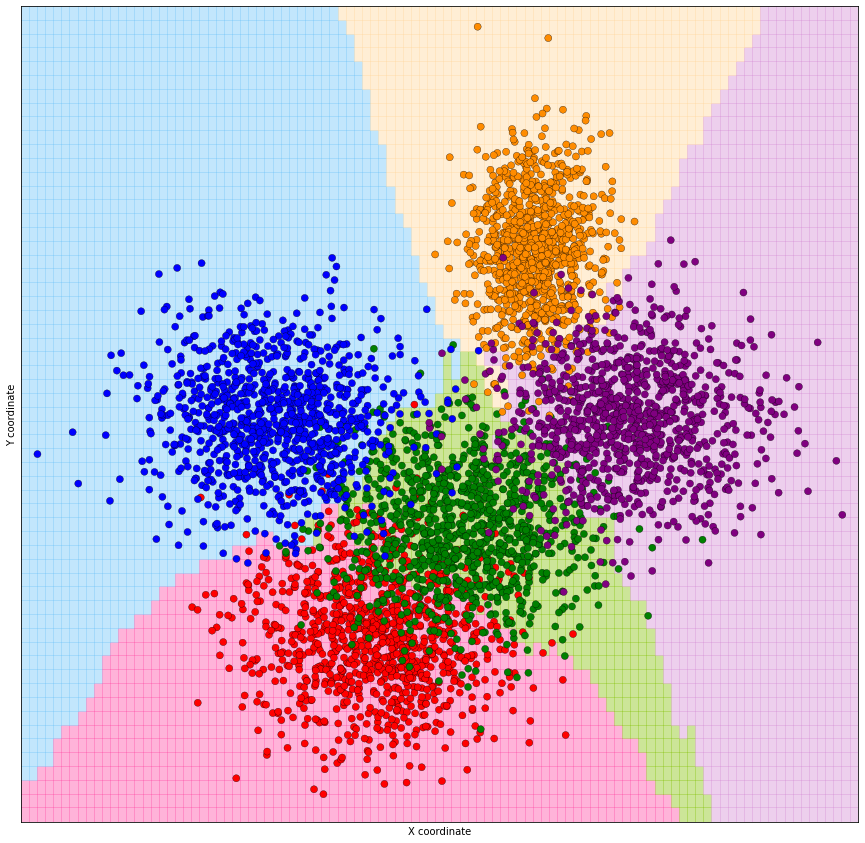

In [24]:
xx, yy, prediction_grid, confidence_grid = knn_prediction_grid(total, k=10, plot=True, plot_format="normal")

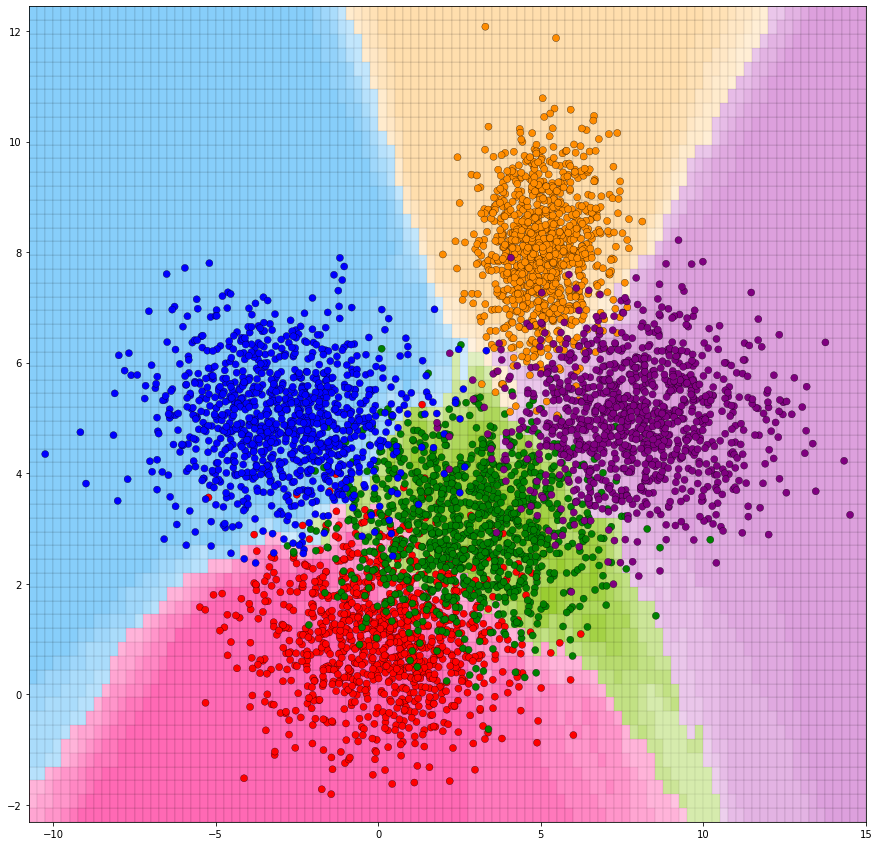

In [25]:
xx, yy, prediction_grid, confidence_grid = knn_prediction_grid(total, k=10, plot=True, plot_format="confidence")

## Testeando el algoritmo
Ahora, vamos a dividir nuestro set de puntos en dos conjuntos, uno de entrenamiento (con los cuales se va generar el modelo) y otro de testing (con los cuales se va a validar nuestro modelo). Con estos dos conjuntos ahora podemos obtener la coherencia de nuestro algoritmo. Como conocemos las clases de los puntos del conjunto de test, podemos determinar si nuestro algoritmo predice bien o no. En base a eso contamos la cantidad de veces que predecimos bien y lo dividimos por el tamaño del conjunto de test. Con esto obtenemos la coherencia, que es un parámetro que nos permite saber si nuestro algoritmo está clasificando bien. El valor de la coherencia va a ir cambiando según el parámetro k, osea, la cantidad de vecinos más cercanos que consideremos

### Dividir el conjunto en Training y Test

En la siguiente función dividimos los datos en estos dos conjuntos

In [26]:
def split(points, training_prop, test_prop, seed=10):
    
    """
    This function takes:
        * the total set of points,
        * the training proportion, which indicates the proportion of the total set that we want for training,
        * the test proportion, which indicates the proportion of the total set that we want for testing.
    
    training_prop + test_prop must be 1, otherwise the function returns an exception.
    
    The result of the function are two differents sets extracted from the total set of points:
        * the training set, and
        * the test set
    """
    
    if training_prop + test_prop != 1:
        raise Exception("ValueError: Proportions of training and test sets must sums 1.")
        
    points_copy = points.copy()
    np.random.seed(seed)
    np.random.shuffle(points_copy)
    
    split_point = round(len(points)*training_prop)
    
    training = points_copy[:split_point]
    test = points_copy[split_point:]
    
    return (training, test)

In [27]:
training, test = split(total, 0.8, 0.2)

A continuación podemos ver como los conjuntos de training y test se asemejan en su distribución, por lo tanto, la división se ha hecho bien y el conjunto de test es válido para validar el modelo ya que se comporta de a misma manera que el conjunto de training. Distinto sería si los conjuntos difieren en su comportamiento

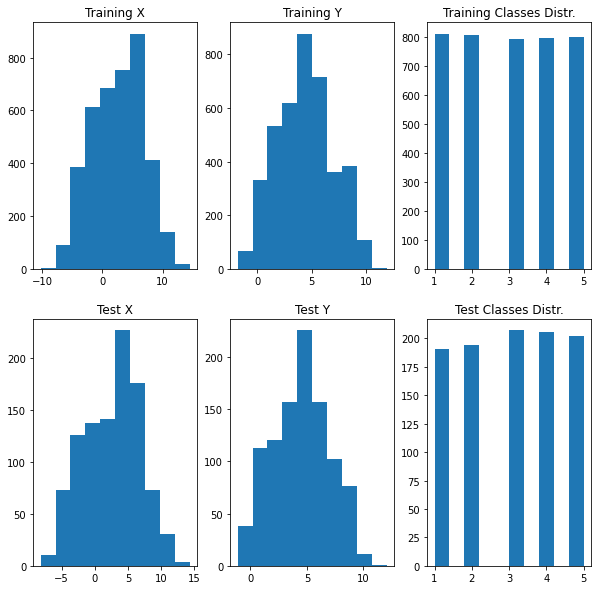

In [28]:
%matplotlib inline
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(10,10))
ax11.hist(training[:,0])
ax12.hist(training[:,1])
ax13.hist(training[:,2])
ax21.hist(test[:,0])
ax22.hist(test[:,1])
ax23.hist(test[:,2])
ax11.set_title("Training X")
ax12.set_title("Training Y")
ax13.set_title("Training Classes Distr.")
ax21.set_title("Test X")
ax22.set_title("Test Y")
ax23.set_title("Test Classes Distr.");

Aquí vemos algunos puntos de los conjuntos de training y test

In [29]:
training

array([[-2.75697445,  1.1945785 ,  1.        ],
       [ 6.47755898,  7.30787833,  5.        ],
       [ 8.99883885,  5.65464266,  5.        ],
       ...,
       [-2.2103899 ,  5.02202868,  3.        ],
       [ 2.10857316, -0.27810197,  1.        ],
       [ 5.25333222,  3.6139623 ,  2.        ]])

In [30]:
test

array([[ 4.07345376,  6.93048787,  4.        ],
       [-0.36213253,  0.90922608,  1.        ],
       [11.25747218,  4.13864696,  5.        ],
       ...,
       [ 2.53857221,  2.81636354,  2.        ],
       [ 6.74782687,  4.29827977,  5.        ],
       [ 3.74003956,  3.11474694,  2.        ]])

### Obtenemos la coherencia
Dado el conjunto de training, el de test y el parámetro k, predecimos cada punto del conjunto de test y contamos la cantidad de veces que acertamos para calcular la coherencia, la cual va a ir cambiando dependiendo del parámetro K. Lo mejor es obtener el K más óptimo para clasificar datos nuevos, que el algoritmo nunca ha tratado.

In [31]:
def test_knn(training, test, k):
    """
        This function takes the training set of points , the test set of points and the parameter K.
        It applies the knn algorythm for every point in the test set and it returns the value of coherence counting 
        the number of times that the prediction is good and then dividing this value above the total number of cases (in the test set).
    """
    
    test_with_predictions = np.concatenate((test, np.zeros((len(test), 2))), axis = 1)
    for point in test_with_predictions:
        point[3], point[4] = knn_predict(training, point, k)
    
    positive_predictions = np.where(test_with_predictions[:,2] == test_with_predictions[:,3])[0].size
    
    return positive_predictions / len(test)

In [32]:
coherence = test_knn(training, test, 10)
coherence

0.907

In [34]:
def get_confusion_matrix_binary(training, test, k, threshold=None):
    test_with_predictions = np.concatenate((test, np.zeros((len(test), 2))), axis = 1)
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for point in test_with_predictions:
        point[3], point[4] = knn_predict(training, point, k)
        actual_value = point[2]
        opposite_predicted_value = 1 if point[3] == 2 else 2
        if threshold is not None: 
            prediction = point[3] if point[4]>= threshold else opposite_predicted_value
        else:
            prediction = point[3]
        
        if actual_value == 1 and prediction == 1:
            TP += 1
        elif actual_value == 2 and prediction == 2:
            TN += 1
        elif actual_value == 2 and prediction == 1:
            FP += 1
        elif actual_value == 1 and prediction == 2:
            FN += 1

    confusion_matrix = np.array([[TP, FN],[FP, TN]])
    return confusion_matrix

In [35]:
class1 = generate_random_class_points(0, 1, 1, 1, 200, 1)
class2 = generate_random_class_points(1, 1, 2, 1, 200, 2)
full_set = join_groups((class1, class2))
training_set, test_set = split(full_set, 0.8, 0.2)

In [37]:
get_confusion_matrix_binary(training_set, test_set, 10)

array([[26, 13],
       [11, 30]])

In [38]:
def get_class_confusion_matrix(training, test, classLabel, k, threshold=None):
    test_with_predictions = np.concatenate((test, np.zeros((len(test), 2))), axis = 1)
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for point in test_with_predictions:
        point[3], point[4] = knn_predict(training, point, k)
        actual_value= point[2]
        opposite_predicted_value = classLabel if point[3] != classLabel else 0
        if threshold is not None:
            prediction = point[3] if point[4]>= threshold else opposite_predicted_value
        else:
            prediction = point[3]
        
        if actual_value == classLabel and prediction == classLabel:
            TP += 1
        elif actual_value != classLabel and prediction != classLabel:
            TN += 1
        elif actual_value != classLabel and prediction == classLabel:
            FP += 1
        elif actual_value == classLabel and prediction != classLabel:
            FN += 1

    confusion_matrix = np.array([[TP, FN],[FP, TN]])
    return confusion_matrix

In [39]:
matrix = get_class_confusion_matrix(training, test, 3, 10)
matrix

array([[200,   7],
       [  9, 784]])

In [40]:
def get_cm_metrics(confusion_matrix):
    TP = confusion_matrix[0][0]
    TN = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    sensitivity = TP / (TP+FN)
    accuracy = (TP+TN) / (TP+FN+TN+FP) 
    specificity = TN / (TN+FP)
    ba = (sensitivity+specificity)/2
    precision = TP / (TP+FP)
    npv = TN / (TN+FN)
    miss_rate = FN / (FN+TP)
    fall_out = FP / (FP+TN)
    fdr = FP / (FP+TP)
    false_or = FN / (FN+TN)
    f_score = 2*sensitivity*precision/(sensitivity+precision)
    output = {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "negative_predictive_value": npv,
        "miss_rate": miss_rate,
        "fall_out": fall_out,
        "false_discovery_rate": fdr,
        "false_omission_rate": false_or,
        "accuracy": accuracy,
        "balanced_accuracy": ba,
        "f_score": f_score
    }
    return output

In [41]:
get_cm_metrics(matrix)

{'sensitivity': 0.9569377990430622,
 'specificity': 0.9911504424778761,
 'precision': 0.966183574879227,
 'negative_predictive_value': 0.9886506935687264,
 'miss_rate': 0.0430622009569378,
 'fall_out': 0.008849557522123894,
 'false_discovery_rate': 0.033816425120772944,
 'false_omission_rate': 0.011349306431273645,
 'accuracy': 0.984,
 'balanced_accuracy': 0.9740441207604691,
 'f_score': 0.9615384615384616}

In [42]:
def get_classes_confusion_matrixes(training, test, k):
    classes_quantity = np.unique(training[:,2]).size
    confusion_matrixes = []
    for i in range(classes_quantity):
        confusion_matrix = get_class_confusion_matrix(training, test, i+1, k)
        confusion_matrixes.append(confusion_matrix)
    return np.array(confusion_matrixes)

In [43]:
confusion_matrixes = get_classes_confusion_matrixes(training, test, 10)
confusion_matrixes    

array([[[170,  21],
        [ 18, 791]],

       [[158,  36],
        [ 36, 770]],

       [[200,   7],
        [  9, 784]],

       [[198,   8],
        [ 12, 782]],

       [[181,  21],
        [ 18, 780]]])

In [44]:
def get_cm_metrics_multiple_classes(confusion_matrixes):
    n = len(confusion_matrixes)
    cms_metrics = []
    for i in range(n):
        cm_metrics = get_cm_metrics(confusion_matrixes[i])
        cms_metrics.append(cm_metrics)
        
    sensitivity = 0
    accuracy = 0
    specificity = 0
    precision = 0
    npv = 0
    miss_rate = 0
    fall_out = 0
    fdr = 0
    false_or = 0
    
    for cm_metrics in cms_metrics:
        sensitivity += cm_metrics["sensitivity"]  
        specificity += cm_metrics["specificity"]
        precision += cm_metrics["precision"]
        npv += cm_metrics["negative_predictive_value"]
        miss_rate += cm_metrics["miss_rate"]
        fall_out += cm_metrics["fall_out"]
        fdr += cm_metrics["false_omission_rate"]
        false_or += cm_metrics["false_omission_rate"]
        accuracy += cm_metrics["accuracy"]
        
    sensitivity = sensitivity/n
    accuracy = accuracy/n
    specificity = specificity/n
    precision = precision/n
    npv = npv/n
    miss_rate = miss_rate/n
    fall_out = fall_out/n
    fdr = fdr/n
    false_or = false_or/n
    f_score = 2*sensitivity*precision/(sensitivity+precision)
    ba = (sensitivity+specificity)/2
    
    output = {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "negative_predictive_value": npv,
        "miss_rate": miss_rate,
        "fall_out": fall_out,
        "false_discovery_rate": fdr,
        "false_omission_rate": false_or,
        "accuracy": accuracy,
        "balanced_accuracy": ba,
        "f_score": f_score
    }
    return output

In [45]:
get_cm_metrics_multiple_classes(confusion_matrixes)

{'sensitivity': 0.9056061978866661,
 'specificity': 0.976855910072502,
 'precision': 0.9055747146189953,
 'negative_predictive_value': 0.9768132498163752,
 'miss_rate': 0.09439380211333395,
 'fall_out': 0.0231440899274979,
 'false_discovery_rate': 0.023186750183624788,
 'false_omission_rate': 0.023186750183624788,
 'accuracy': 0.9628,
 'balanced_accuracy': 0.9412310539795841,
 'f_score': 0.9055904559791982}

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [47]:
def plot_binary_classification_roc_metric(training_set, test_set, k):
    test_with_predictions = np.concatenate((test_set, np.zeros((len(test_set), 2))), axis = 1)
    for point in test_with_predictions:
        point[3], point[4] = knn_predict(training_set, point, k)

    values = np.where(test_with_predictions[:,2]==2, 0,test_with_predictions[:,2])
    probability_scores = [point[4] if point[3] == 1 else (1-point[4]) for point in test_with_predictions]
        
    fpr, tpr, threshold = roc_curve(values, probability_scores)
    roc_auc = auc(fpr, tpr)
    
    fig = plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr,'bo-', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0,1],[0,1],'r--', label="AUC = 0.5")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("1-Especificidad o Ratio de falsos positivos")
    plt.ylabel("Sensibilidad o Ratio de verdaderos positivos")
    plt.title("Curva ROC de KNN con K = " + str(k))
    plt.legend()
    
    return fig, fpr, tpr, roc_auc, threshold

(<Figure size 720x720 with 1 Axes>,
 array([0.        , 0.02439024, 0.09756098, 0.09756098, 0.12195122,
        0.17073171, 0.26829268, 0.3902439 , 0.70731707, 0.85365854,
        0.90243902, 1.        ]),
 array([0.        , 0.23076923, 0.33333333, 0.48717949, 0.58974359,
        0.58974359, 0.66666667, 0.74358974, 0.97435897, 1.        ,
        1.        , 1.        ]),
 0.775797373358349,
 array([2. , 1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]))

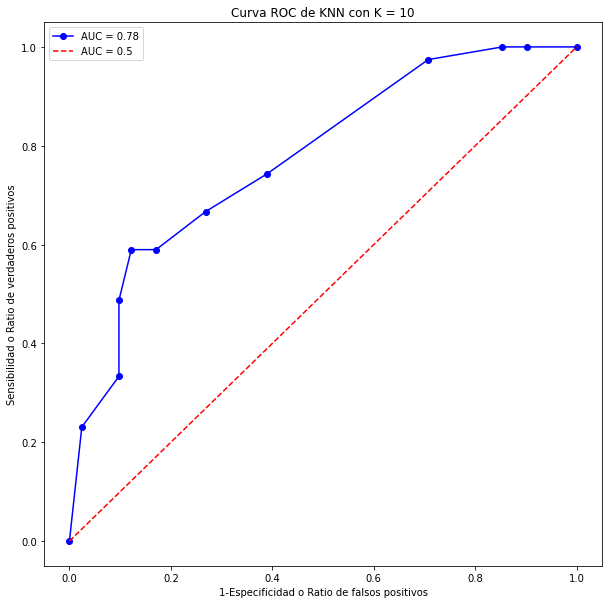

In [48]:
plot_binary_classification_roc_metric(training_set, test_set, 10)

In [49]:
def plot_multiple_classification_roc_metric(training_set, test_set, k):
    classes_quantity = np.unique(training_set[:,2]).size
    test_with_predictions = np.concatenate((test_set, np.zeros((len(test_set), 2))), axis = 1)
    for point in test_with_predictions:
        point[3], point[4] = knn_predict(training_set, point, k)
    
    fig = plt.figure(figsize=(10,10))
    fprs = []
    tprs = []
    roc_aucs = []
    for i in range(classes_quantity):
        
        values = np.where(test_with_predictions[:,2] != i+1, 0, test_with_predictions[:,2])
        probability_scores = [point[4] if point[3] == i+1 else (1-point[4]) for point in test_with_predictions]

        fpr, tpr, threshold = roc_curve(values, probability_scores, pos_label=i+1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,'o-', label = 'AUC = %0.2f (Class ' % roc_auc + str(i+1) + ')')
        
        fprs.append(fpr)
        tprs.append(tpr)
        roc_aucs.append(roc_auc)
        
    plt.plot([0,1],[0,1],'r--', label="AUC = 0.5")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("1-Especificidad o Ratio de falsos positivos")
    plt.ylabel("Sensibilidad o Ratio de verdaderos positivos")
    plt.title("Curva ROC de KNN con K = " + str(k))
    plt.legend()
    return fig, fprs, tprs, roc_aucs

In [50]:
get_classes_confusion_matrixes(training, test, 10)

array([[[170,  21],
        [ 18, 791]],

       [[158,  36],
        [ 36, 770]],

       [[200,   7],
        [  9, 784]],

       [[198,   8],
        [ 12, 782]],

       [[181,  21],
        [ 18, 780]]])

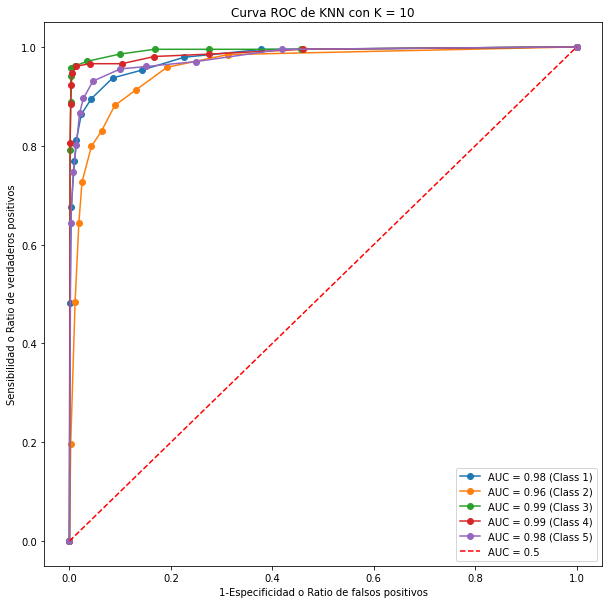

In [51]:
plot_multiple_classification_roc_metric(training, test, 10);

In [60]:
def test_multiple_knn(training, test, lastk = 10, plot=True):
    """
    This function takes the training and test set to obtain the model's coherences for multiple k_values
    and plots the (k, coherence) graphic if needed
    
    Inputs:
    'training': the training set (np.ndarray),
    'test': the test set (np.ndarray),
    'lastk': With how many k values you want to test the model? K is taken from 1 to lastk (integer, default = 10),
    'plot': Whether you want or not the plot (bool, default = True).
    
    Output:
    'coherences': an np.ndarray containing the coherences values for the differents k values asked for.
    """
    
    coherences = np.array(())
    for i in range(1, lastk + 1):
        coherences = np.append(coherences,[test_knn(training, test, i)])
    if plot:    
        fig = plt.figure(figsize=(10,10)) 
        plt.plot(np.array(list(range(1, lastk + 1))), coherences);
        plt.title("KNN con K de 1 a "+str(lastk) )
        plt.xlabel("Valor K")
        plt.ylabel("Coherencia");
    return coherences,fig

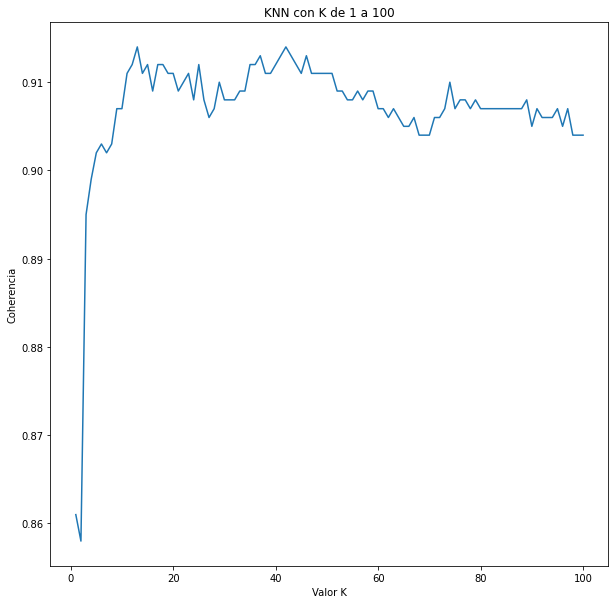

In [61]:
test_multiple_knn(training, test, 100);

## Ejemplos con casos prácticos
A continuación se mostrarán ejemplos de casos prácticos a los cuales se aplicará el algoritmo Knn. 


### Clasificación de jóvenes en la escuela de EEUU

El siguiente dataset ya está dividido en train y test. Se trata de información de tamaño de zapatos y altura de jóvenes en la escuela en Estados Unidos y clasificados como "Seniors" (Clase 1), los cuales son los alumnos del ultimo año de secundaria; y "Fourth" (Clase 2), los cuales son alumnos del último año de Primaria

In [85]:
import pandas as pd

Cargamos los datos con la librería pandas. Luego cambiamos en ambos datasets (train y test) la clasificación de "Seniors" y "Fourth" por 1 y 2.

In [ ]:
training = pd.read_csv("train.csv")
training.head()
training.tail()

In [ ]:
training = training.replace(["seniors", "fourth"],[1,2])

In [ ]:
training = training.to_numpy()
training

In [ ]:
test = pd.read_csv("test.csv")
test.head()

In [ ]:
test = test.replace(["seniors","fourth"],[1,2])

In [ ]:
test = test.to_numpy()
test.shape

Observamos que los datos de train y test se comportan de la misma manera

In [ ]:
%matplotlib inline
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(10,10))
ax11.hist(training[:,0])
ax12.hist(training[:,1])
ax13.hist(training[:,2])
ax21.hist(test[:,0])
ax22.hist(test[:,1])
ax23.hist(test[:,2])
ax11.set_title("Training X")
ax12.set_title("Training Y")
ax13.set_title("Training Classes Distr.")
ax21.set_title("Test X")
ax22.set_title("Test Y")
ax23.set_title("Test Classes Distr.");

Calculamos la coherencia del modelo. Obtenemos un excelente valor con cualquier número para k

In [ ]:
test_knn(training, test, 6)

In [ ]:
test_multiple_knn(training, test, 20);

Calculamos y graficamos la grilla con los datos reales. Además incluímos los datos del conjunto de testing, con los colores negros y amarillos, para diferenciarlos. Vemos que sólo hay un punto en el cual el modelo clasifica mal. 

In [ ]:
usa_school_grid = knn_prediction_grid(training, 10, plot=True, h=0.1,plot_format='confidence')
#plt.scatter(test[:,0],test[:,1],c = test[:,2]);

### Clasificación de flores Iris
El siguiente dataset es bastante histórico, se trata de valores de ancho y largo de pétalos y sépalos de flores Iris. Estos valores varían según el tipo de flor iris (Setosa, Versicolor y Virginica). Para este ejemplo tomamos sólo los valores de ancho y largo del sépalo para clasificar las flores. El dataset lo sacamos de la librería scikit learn. En este caso hay que dividir el conjunto en training y test usando nuestra función y también unimos los valores de las clases con los puntos ya que estos vienen de forma separada.

In [86]:
from sklearn import datasets
iris = datasets.load_iris()

In [ ]:
data = iris.data[:,:2]

In [ ]:
data.shape

In [ ]:
outcomes = iris.target

In [ ]:
outcomes = np.reshape(outcomes, (150,1))

In [ ]:
outcomes.shape

In [ ]:
data = np.concatenate((data, outcomes), axis=1)
data

In [ ]:
train_data, test_data = split(data, 0.8, 0.2)

In [ ]:
train_data.shape

In [ ]:
test_data.shape

En este caso, vemos como los conjuntos de test y train no se compotan de manera tan parecida, esto puede ser a la poca cantidad de datos que tenemos (sólo 150, 120 para entrenar, 30 para testear). 

In [ ]:
%matplotlib inline
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(10,10))
ax11.hist(train_data[:,0])
ax12.hist(train_data[:,1])
ax13.hist(train_data[:,2])
ax21.hist(test_data[:,0])
ax22.hist(test_data[:,1])
ax23.hist(test_data[:,2])
ax11.set_title("Training X")
ax12.set_title("Training Y")
ax13.set_title("Training Classes Distr.")
ax21.set_title("Test X")
ax22.set_title("Test Y")
ax23.set_title("Test Classes Distr.");

Como lo esperábamos, debido a la poca cantidad de datos, y por sólo tomar dos columnas de las cuatro existentes (se podría obtener mejores valores para clasificar si haríamos alguna transformación como sumar ancho y largos de sépalos y pétalos, u obteniendo los componentes principales con el algoritmo de PCA), no obtenemos un valor muy acertado de coherencia, y eso también se refleja en el gráfico de la grilla más abajo.

In [ ]:
test_knn(train_data, test_data, 8)

In [ ]:
test_multiple_knn(train_data, test_data, lastk=30);

In [ ]:
iris_grid = knn_prediction_grid(train_data, k=1, plot=True, h=0.01 ,plot_format='normal')
#plt.scatter(test_data[:,0],test_data[:,1],c = test_data[:,2]);

### Clasificación Iris considerando las 4 columnas
En este caso sumamos los valores de ancho y largo de los sépalos para obtener los datos en x, y los valores de ancho y largo de los pétalos para obtener los datos en y. De esta manera, quizás la clasificación mejore.

In [87]:
data = iris.data
data = np.array([data[:,0] + data[:,1], data[:,2] + data[:,3], iris.target]).transpose()

In [88]:
data.shape

(150, 3)

In [ ]:
train_data, test_data = split(data, 0.8, 0.2)

En este caso, los conjuntos de datos se comportan de manera similar.

In [ ]:
%matplotlib inline
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(10,10))
ax11.hist(train_data[:,0])
ax12.hist(train_data[:,1])
ax13.hist(train_data[:,2])
ax21.hist(test_data[:,0])
ax22.hist(test_data[:,1])
ax23.hist(test_data[:,2])
ax11.set_title("Training X")
ax12.set_title("Training Y")
ax13.set_title("Training Classes Distr.")
ax21.set_title("Test X")
ax22.set_title("Test Y")
ax23.set_title("Test Classes Distr.");

Ahora obtenemos un valor muy alto de coherencia. De hecho, con la mayoría de los valores de k obtenemos coherencias del 100%.

In [ ]:
test_knn(train_data, test_data,22)

In [ ]:
test_multiple_knn(train_data, test_data, 119);

In [ ]:
performanted_iris_grid = knn_prediction_grid(train_data, k=1, plot=True, h=0.01,plot_format="normal")
plt.scatter(test_data[:,0],test_data[:,1],c = test_data[:,2]);

## Tests con Cross Validation
**Hipótesis**: *Testeando el algoritmo con el método de Validación cruzada obtenemos resultados más confiables*.

Al aumentar K la precision del modelo varía (aumenta o disminuye) de forma más suave que si testeamos con el método de validación dividiendo el conjunto en training y test. Esto se puede comprobar con los valores de desviación estandar del conjunto de accuracies y los percentiles. En el caso de validación cruzada los accuracies tienen mucha menos variación que con la validación normal.

In [121]:
def test_cross_validation(points, k, cv=5, seed=10):
    subsets_size = round(len(points) / cv)
    points_copy = points.copy()
    np.random.seed(seed)
    np.random.shuffle(points_copy)
    subsets = []
    corteMin = 0
    corteMax = subsets_size
    for i in range(cv-1):
        subset = points_copy[corteMin:corteMax]
        subsets.append(subset)
        corteMin = corteMax
        corteMax = corteMax + subsets_size
    subset = points_copy[corteMin:]
    subsets.append(subset)
    accuracies = []
    for i in range(cv):
        test = subsets[i]
        if i == 0:
            training = np.concatenate(subsets[i+1:])
        elif i == cv-1:
            training = np.concatenate(subsets[:i])
        else:
            training1 = np.concatenate(subsets[:i])
            training2 = np.concatenate(subsets[i+1:])
            training = np.concatenate((training1, training2))
        accuracy = test_knn(training, test, k=k)
        accuracies.append(accuracy)
    accuracies = np.array(accuracies)
    return (accuracies, np.mean(accuracies))    

In [122]:
test_cross_validation(total,10)

(array([0.888, 0.889, 0.908, 0.891, 0.907]), 0.8966000000000001)

In [123]:
def plot_test_cross_validation_results(points, k_max=10, cv=5, seed=10):
    coherences = []
    for i in range(1,k_max+1):
        coherences.append(test_cross_validation(points, i, cv, seed)[1])
    coherences = np.array(coherences)
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(1,k_max+1)),coherences)
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.title("Validación cruzada para K de 1 a "+str(k_max))
    return coherences, fig

(array([0.8488, 0.8506, 0.879 , 0.8836, 0.8882, 0.893 , 0.8932, 0.8946,
        0.897 , 0.898 , 0.8982, 0.8984, 0.8982, 0.9   , 0.9   , 0.9014,
        0.9018, 0.9026, 0.902 , 0.9026, 0.9018, 0.9006, 0.9008, 0.9006,
        0.901 ]), <Figure size 720x720 with 1 Axes>)

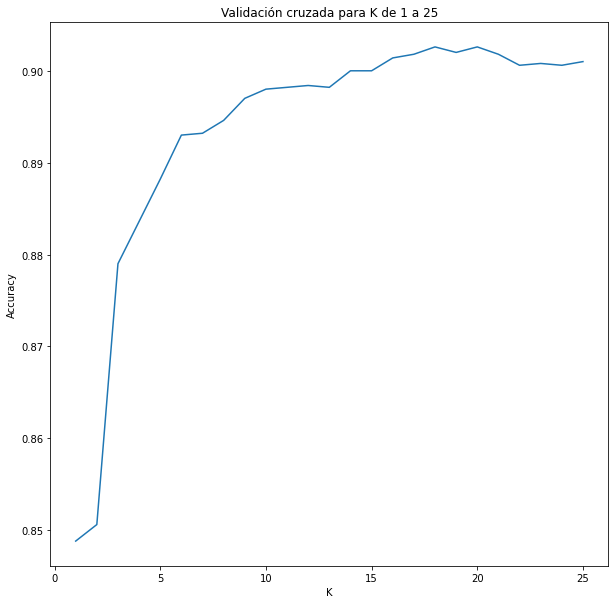

In [124]:
plot_test_cross_validation_results(total,25,10)

In [66]:
def plot_test_normal_validation(points, train_prop, seed, k_max=25):
    training, test = split(points, train_prop, 1-train_prop, seed)
    return test_multiple_knn(training, test, k_max)

(array([0.861, 0.858, 0.895, 0.899, 0.902, 0.903, 0.902, 0.903, 0.907,
        0.907, 0.911, 0.912, 0.914, 0.911, 0.912, 0.909, 0.912, 0.912,
        0.911, 0.911, 0.909, 0.91 , 0.911, 0.908, 0.912]),
 <Figure size 720x720 with 1 Axes>)

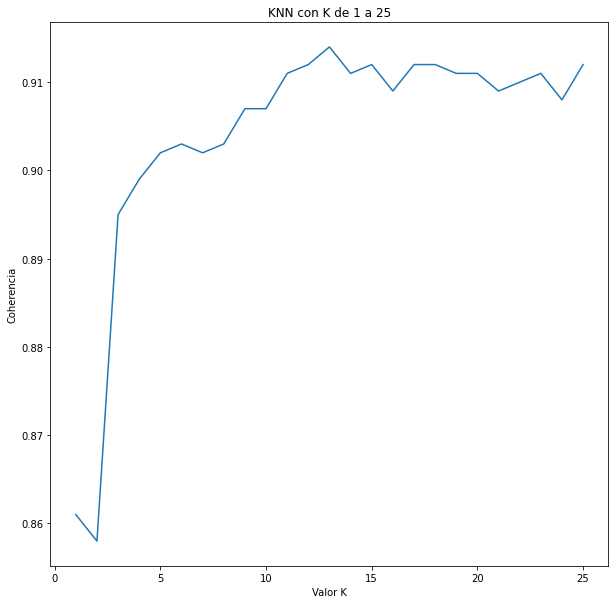

In [62]:
plot_test_normal_validation(total, 0.8, 10)

In [67]:
def get_normal_validation_metrics(points, train_prop, seed=10, k_max):
    values_nv, graph_nv = plot_test_normal_validation(points, train_prop, seed, k_max)
    mean_nv = np.mean(values_nv)
    stdev_nv = np.std(values_nv)
    min_nv = np.min(values_nv)
    max_nv = np.max(values_nv)
    percentile25th_nv = np.percentile(values_nv, 25)
    median_nv =np.median(values_nv)
    percentile75th_nv = np.percentile(values_nv, 75)
    output = {
        "Mean": mean_nv,
        "Standard Deviation": stdev_nv,
        "Min Value": min_nv,
        "Max Value": max_nv,
        "Percentile 25th": percentile25th_nv,
        "Median": median_nv,
        "Percentile 75th": percentile75th_nv, 
    }
    return values_nv, graph_nv, output

In [69]:
def get_cross_validation_metrics(points, k_max, cv=5, seed=10):
    values_cv, graph_cv = plot_test_cross_validation_results(points, k_max, cv, seed)
    mean_cv = np.mean(values_cv)
    stdev_cv = np.std(values_cv)
    min_cv = np.min(values_cv)
    max_cv = np.max(values_cv)
    percentile25th_cv = np.percentile(values_cv, 25)
    median_cv =np.median(values_cv)
    percentile75th_cv = np.percentile(values_cv, 75)
    output = {
        "Mean": mean_cv,
        "Standard Deviation": stdev_cv,
        "Min Value": min_cv,
        "Max Value": max_cv,
        "Percentile 25th": percentile25th_cv,
        "Median": median_cv,
        "Percentile 75th": percentile75th_cv,
    }
    return values_cv, graph_cv, output

In [71]:
# Creamos un conjunto de 200 puntos con 100 de una clase y 100 de otra para comprobar
class1 = generate_random_class_points(0, 2, 1, 1, 100, 1)
class2 = generate_random_class_points(5, 3, 2, 0.5, 100, 2)
all_points = join_groups((class1, class2))

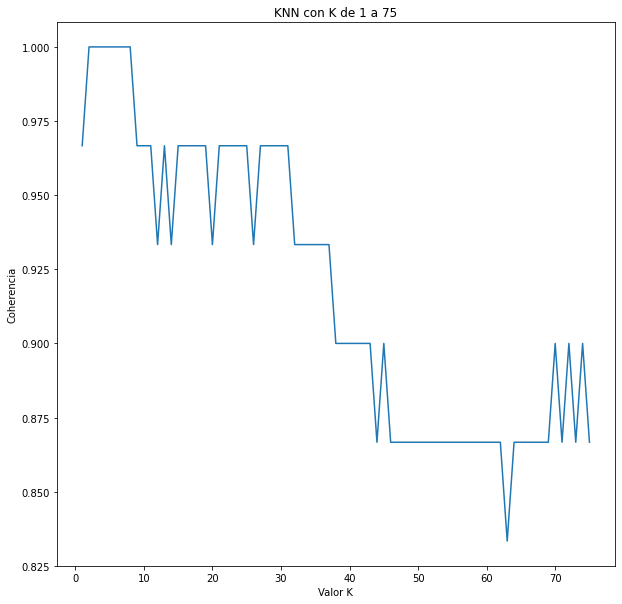

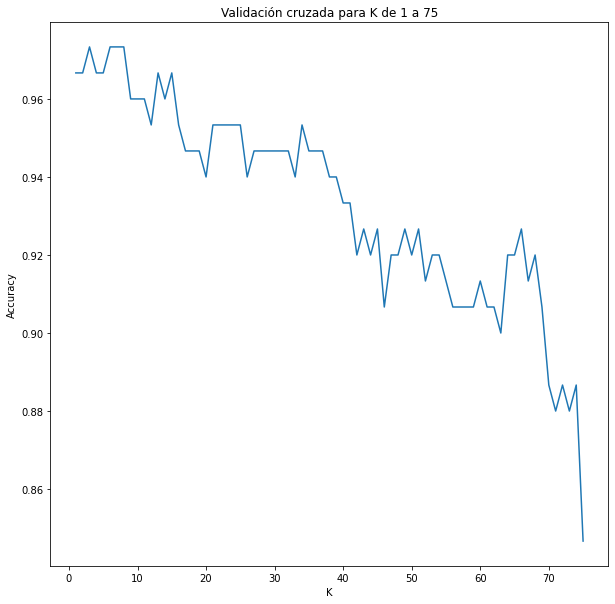

In [97]:
nv_metrics = get_normal_validation_metrics(data, 0.8, 10, 75)
cv_metrics = get_cross_validation_metrics(data, 75, 5, 10)

In [98]:
nv_metrics[2]

{'Mean': 0.9186666666666667,
 'Standard Deviation': 0.04875942454009769,
 'Min Value': 0.8333333333333334,
 'Max Value': 1.0,
 'Percentile 25th': 0.8666666666666667,
 'Median': 0.9,
 'Percentile 75th': 0.9666666666666667}

In [99]:
cv_metrics[2]

{'Mean': 0.9332444444444443,
 'Standard Deviation': 0.02622960348090366,
 'Min Value': 0.8466666666666665,
 'Max Value': 0.9733333333333334,
 'Percentile 25th': 0.9166666666666666,
 'Median': 0.9400000000000001,
 'Percentile 75th': 0.9533333333333334}

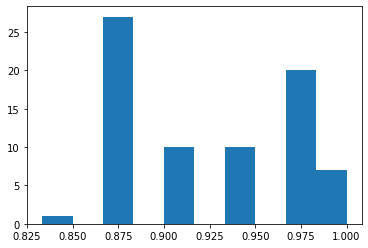

In [100]:
plt.hist(nv_metrics[0]);

(array([ 1.,  0.,  2.,  3.,  9., 14.,  7., 17., 12., 10.]),
 array([0.84666667, 0.85933333, 0.872     , 0.88466667, 0.89733333,
        0.91      , 0.92266667, 0.93533333, 0.948     , 0.96066667,
        0.97333333]),
 <a list of 10 Patch objects>)

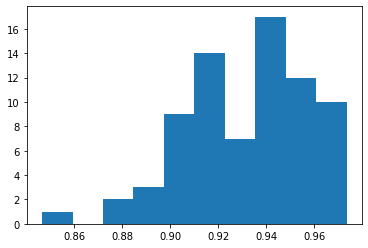

In [101]:
plt.hist(cv_metrics[0])

In [111]:
class1 = generate_random_class_points(0, 2, 1, 1, 100, 1)
class2 = generate_random_class_points(4, 2, 4, 1, 100, 2)
class3 = generate_random_class_points(8, 2, 7, 1, 100, 3)
all_points = join_groups((class1, class2, class3))

array([[-9.64186278e-01,  1.94712608e+00,  1.00000000e+00],
       [ 1.79175225e-01, -2.23106923e-02,  1.00000000e+00],
       [ 1.65399725e+00,  2.16716837e+00,  1.00000000e+00],
       [-3.90902424e+00,  4.28023187e-01,  1.00000000e+00],
       [ 2.34951322e-01,  1.13313750e+00,  1.00000000e+00],
       [-3.81491378e+00,  2.20274387e+00,  1.00000000e+00],
       [-1.84581853e+00, -2.47529670e-02,  1.00000000e+00],
       [ 9.39502868e-01,  1.16039916e+00,  1.00000000e+00],
       [-2.88733526e-01, -1.30475287e-01,  1.00000000e+00],
       [-8.00276704e-01, -9.41299681e-01,  1.00000000e+00],
       [-5.91967706e-01,  1.98659782e+00,  1.00000000e+00],
       [ 1.69641722e+00,  1.02822737e+00,  1.00000000e+00],
       [ 1.41366091e+00,  1.77632402e-01,  1.00000000e+00],
       [-1.57453785e+00, -5.86551761e-01,  1.00000000e+00],
       [ 5.85881450e-01,  5.98527181e-01,  1.00000000e+00],
       [-9.41614503e-01,  2.34217928e+00,  1.00000000e+00],
       [ 4.80865121e+00,  1.40246909e+00

In [112]:
all_points = pd.DataFrame(all_points, columns=["X","Y","Label"])
all_points

,X,Y,Label
0,2.079956,1.603364,1.0
1,-0.981279,1.766959,1.0
2,0.060816,1.361807,1.0
3,-3.557666,1.603281,1.0
4,-1.205420,2.102552,1.0
5,0.104533,1.410938,1.0
6,1.413117,2.199534,1.0
7,0.154075,1.478689,1.0
8,-3.540679,1.784999,1.0
9,-0.100281,0.567717,1.0


In [113]:
all_points.to_csv("test_dataset1.csv", index=False)

In [114]:
data = {
    "C1": 1,
    "C2": 2
}

In [116]:
data["C1"]

1

In [120]:
list(data.keys())[1]

'C2'

{'whiskers': [<matplotlib.lines.Line2D at 0x1cb7cbab668>,
 'caps': [<matplotlib.lines.Line2D at 0x1cb7cbabda0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cb7cbab518>],
 'medians': [<matplotlib.lines.Line2D at 0x1cb7cbb64e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cb7cbb6860>],
 'means': []}

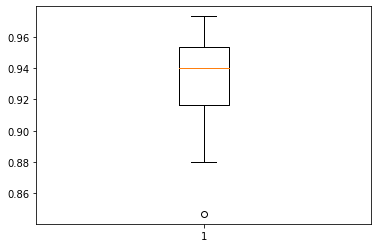

In [125]:
plt.boxplot(cv_metrics[0])

{'whiskers': [<matplotlib.lines.Line2D at 0x1cb7cc07eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x1cb7cc14630>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cb7cc07d68>],
 'medians': [<matplotlib.lines.Line2D at 0x1cb7cc14d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cb7cc1f0f0>],
 'means': []}

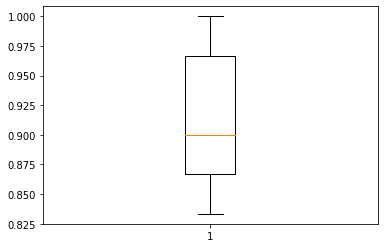

In [127]:
plt.boxplot(nv_metrics[0])